# Introduction

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [41]:
def f(x):
    '''
    Non-linear function
    '''
    return x**2


def f_prime(x):
    '''
    Partial derivative of function f
    '''
    return 2 * x


def f_taylor_order_1(x, x_mean, z_mean):
    '''
    First order Taylore expansion of function f(x)
    '''
    return (f_prime(x) * x_mean) - z_mean

In [42]:
def gaussian_pdf(x, mu, var):
    '''
    probability density function of gaussian distribution
    
    x   : point of interest
    mu  : mean of the distribution
    var : variance of the distribution
    '''
    return (1. / np.sqrt(2. * np.pi * var)) * np.exp(-0.5 * (x - mu)**2 / var)


def generate_normal_samples(mu, var, sigma_num=3, num=300):
    '''
    generate normally distributed 1D [samples, pdfs] such that the mean value
    is included as well in the middle index of the array.
    '''
    sigma = np.sqrt(var)
    sigma_3 = sigma_num * sigma
    x = np.linspace(mu - sigma_3, mu + sigma_3, num)
    middle_idx = int(num / 2)
    x = np.insert(x, middle_idx, mu) # add the mean value to the samples in the correct order of points (middle)
    p = gaussian_pdf(x, mu, var)
    return x, p

In [43]:
def create_plot():
    '''
    create and prepare the 3 subplot figures to be used by the KF visualizer
    '''
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    axes[1, 0].set_axis_off()

    axes[0, 0].axvline(c='grey', lw=2)
    axes[0, 0].axhline(c='grey', lw=2)

    axes[0, 1].axvline(c='grey', lw=2)
    axes[0, 1].axhline(c='grey', lw=2)

    axes[1, 1].axvline(c='grey', lw=2)
    axes[1, 1].axhline(c='grey', lw=2)

    axes[0, 0].grid(visible=True)
    axes[0, 1].grid(visible=True)
    axes[1, 1].grid(visible=True)

    axes[0, 1].set_title('Function Model f', fontsize=30)

    axes[0, 0].set_xlabel('p(z)', fontsize=30)
    axes[0, 0].set_ylabel('output z', fontsize=30)

    axes[1, 1].set_xlabel('input x', fontsize=30)
    axes[1, 1].set_ylabel('p(x)', fontsize=30)

    return fig, axes

In [44]:
class Gaussian(object):
    def __init__(self, samples):
        self.num = len(samples)
        self.mean = self.calculate_mean(samples)
        self.var = self.calculate_covariance(samples)
        
    def calculate_mean(self, samples):
        mean = 0.0
        for x_i in samples:
            mean += x_i
        mean /= len(samples)
        return mean
    
    def calculate_covariance(self, samples):
        var = 0.0
        for x_i in samples:
            var += (x_i - self.mean)**2
        var /= len(samples)
        return var

In [45]:
class MontoCarloSampler(object):
    def __init__(self, nl_model, mean, var, num):
        '''
        Monto-Carlo method is used to calculate the statistics of a random variable
        which undergoes a nonlinear transformation.
        
        nl_model: nonlinear model
        mean: mean of the input normal distribution
        var: variance of the input normal distribution
        num: number of random samples to be drawn from the distribution
        '''
        
        # 1. draw random samples from the normal distribution defined by mean and variance
        self.x_samples = np.random.normal(mean, var, num)
        
        # 2. calculate the pdf of the drawn samples from 'x'
        self.p_x_samples = gaussian_pdf(self.x_samples, mean, var)
        
        # 3. transform the drawn samples through the nonlinear model
        self.z_samples = nl_model(self.x_samples)
        
        # 4. calculate the mean and covariance of the transformed samples.
        z_gauss = Gaussian(self.z_samples)
        
        # 5. set other outputs
        self.num = num
        self.mean = z_gauss.mean
        self.var = z_gauss.var
        
        # 6. calculate the pdf of the transformed samples 'z'
        self.p_z_samples = gaussian_pdf(self.z_samples, z_gauss.mean, z_gauss.var)

In [46]:
class EKF_Visualization(object):
    def __init__(self, model=None, model_taylor=None, x_mean=0.0, x_sigma=0.0, samples_num=100, x_model_range=[-1., 1.], monto_carlo_sizes=[]):        
        '''
        initialize the class object
        
        model : model to be used for projection
        model_taylor : first order Taylor expansions of model f(x)
        
        x_mean : input mean
        x_sigma : input standard deviation
        
        x_model_range : range of values for plotting inputs of model and model_taylor
        z_model_range : range of values for plotting outputs of model and model_taylor
        
        '''
       
        self.xlim_min, self.xlim_max = x_model_range
               
        self.x_mean = x_mean
        self.x_sigma = x_sigma
        
        self.z_mean = model(self.x_mean)
               
        self.model = model
        self.model_taylor = model_taylor
        
        self.fig, self.axes = create_plot()
        
        self.monto_carlo_sizes = monto_carlo_sizes
        
    def update_plot(self):
        '''
        main function to execute the class plotting
        '''
        
        # ==============================================================================================
        # 1. generate 'x' samples to feed to the model 'f(x)'
        #
        x_norm_bel, p_norm_bel = generate_normal_samples(self.x_mean, self.x_sigma, num=50)
        x_norm_pts, p_norm_pts = generate_normal_samples(self.x_mean, self.x_sigma, num=8)
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 2. propagate the 'x' samples through model 'f(x)' to obtain 'z' samples
        #
        x_model_curve = np.linspace(self.xlim_min, self.xlim_max, num=100)
        z_model_curve = self.model(x_model_curve)
        
        z_norm_bel = self.model(x_norm_bel)
        z_norm_pts = self.model(x_norm_pts)
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 3. propagate the 'x' samples through the taylore expansion of model 'f(x)' to obtain 'z' samples
        #
        z_model_taylor = self.model_taylor(x_model_curve, self.x_mean, self.z_mean)
        z_norm_bel_taylor = self.model_taylor(x_norm_bel, self.x_mean, self.z_mean)
        z_norm_pts_taylor = self.model_taylor(x_norm_pts, self.x_mean, self.z_mean)
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 4. Monto-Carlo method: draw normally distributed random samples from 'x' and transform them
        #    through the nonlinear function f(x), then calculate mean and covariance of the 'z' outputs.
        #      
        monto_carlo_sampler_list = []
        z_monto_carlo_approx_list = []
        p_monto_carlo_approx_list = []
        
        for s in self.monto_carlo_sizes:
            monto_carlo_sampler = MontoCarloSampler(nl_model=self.model, mean=self.x_mean, var=self.x_sigma, num=s)
            z_monto_carlo_approx, p_monto_carlo_approx = generate_normal_samples(monto_carlo_sampler.mean, monto_carlo_sampler.var, num=50)
            
            monto_carlo_sampler_list.append(monto_carlo_sampler)
            z_monto_carlo_approx_list.append(z_monto_carlo_approx)
            p_monto_carlo_approx_list.append(p_monto_carlo_approx)
        
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 5. calculate the min and max samples to set plots limits
        #
       
        z_list = [z_norm_bel, z_norm_bel_taylor]
        p_list = [p_norm_bel]
        for i in range(len(z_monto_carlo_approx_list)):
            z_list.append(z_monto_carlo_approx_list[i])
            p_list.append(p_monto_carlo_approx_list[i])
            
        z_lim_min, z_lim_max = np.min(z_list), np.max(z_list)
        
        p_input_max = np.max(p_norm_bel) 
        p_output_max = np.max(p_list)
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 6. set plots limits
        #
        self.axes[0, 0].set_xlim(0., p_output_max)
        self.axes[0, 0].set_ylim(z_lim_min, z_lim_max)
        
        self.axes[1, 1].set_xlim(self.xlim_min, self.xlim_max)
        self.axes[1, 1].set_ylim(0., p_input_max)
        
        self.axes[0, 1].set_xlim(self.xlim_min, self.xlim_max)
        self.axes[0, 1].set_ylim(z_lim_min, z_lim_max)
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 7. plot input normal distribution
        #
        self.axes[1, 1].plot(x_norm_bel, p_norm_bel, color='blue', label='input normal distribution')
        if (len(monto_carlo_sampler_list) == 1):
            self.axes[1, 1].plot(monto_carlo_sampler_list[0].x_samples, monto_carlo_sampler_list[0].p_x_samples, color='red', marker='o', linestyle='', label='input drawn samples') # plot samples
        # ==============================================================================================
    
    
        # ==============================================================================================
        # 8. plot output normal distributions
        # 
        self.axes[0, 0].plot(p_norm_bel, z_norm_bel, color='blue', label='output normal distribution')
        
        if (len(monto_carlo_sampler_list) == 1):
            self.axes[0, 0].plot(monto_carlo_sampler_list[0].p_z_samples, monto_carlo_sampler_list[0].z_samples, color='red', marker='o', linestyle='', label='output transformed samples') # plot samples
        
        self.axes[0, 0].plot(p_norm_bel, z_norm_bel_taylor, color='orange', label='Taylor-1st-Order Distribution')
        
        for i in range(len(monto_carlo_sampler_list)):
            self.axes[0, 0].plot(p_monto_carlo_approx_list[i], z_monto_carlo_approx_list[i], color='black', linestyle=':', label=f'monto-carlo approx N={monto_carlo_sampler_list[i].num}, [mean={round(monto_carlo_sampler_list[i].mean,2)}, var={round(monto_carlo_sampler_list[i].var,2)}]')
        # ==============================================================================================
    
    
        # ==============================================================================================
        # 9. plot model curve
        #        
        self.axes[0, 1].plot(x_model_curve, z_model_curve, color='blue', label='non-linear model f(x)=x')
        
        if (len(monto_carlo_sampler_list) == 1):
            self.axes[0, 1].plot(monto_carlo_sampler_list[0].x_samples, monto_carlo_sampler_list[0].z_samples, color='red', marker='o', linestyle='', label='input/output samples') # plot samples
            
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 10. plot model first order taylor curve
        #   
        self.axes[0, 1].plot(x_model_curve, z_model_taylor, color='orange', label='first order taylor of f(x)')
        # ==============================================================================================

        self.axes[0, 0].legend(loc='upper right')
        self.axes[0, 1].legend(loc='upper right')
        self.axes[1, 1].legend(loc='upper right')
        

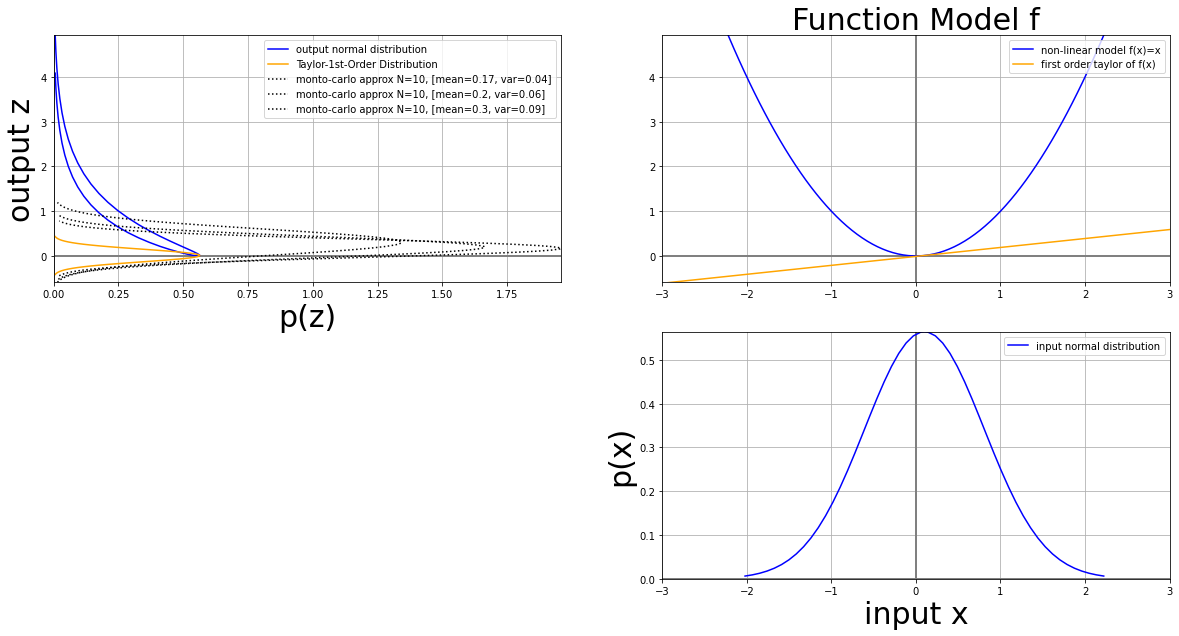

In [47]:
x_range, x_num = (-3., 3.), 100
x_mean, x_sigma = 0.1, 0.5

ekf_visu = EKF_Visualization(
    model=f,
    model_taylor=f_taylor_order_1,
    x_mean=x_mean, x_sigma=x_sigma,
    x_model_range=x_range,
    samples_num=100,
    monto_carlo_sizes=[10, 10, 10])

ekf_visu.update_plot()

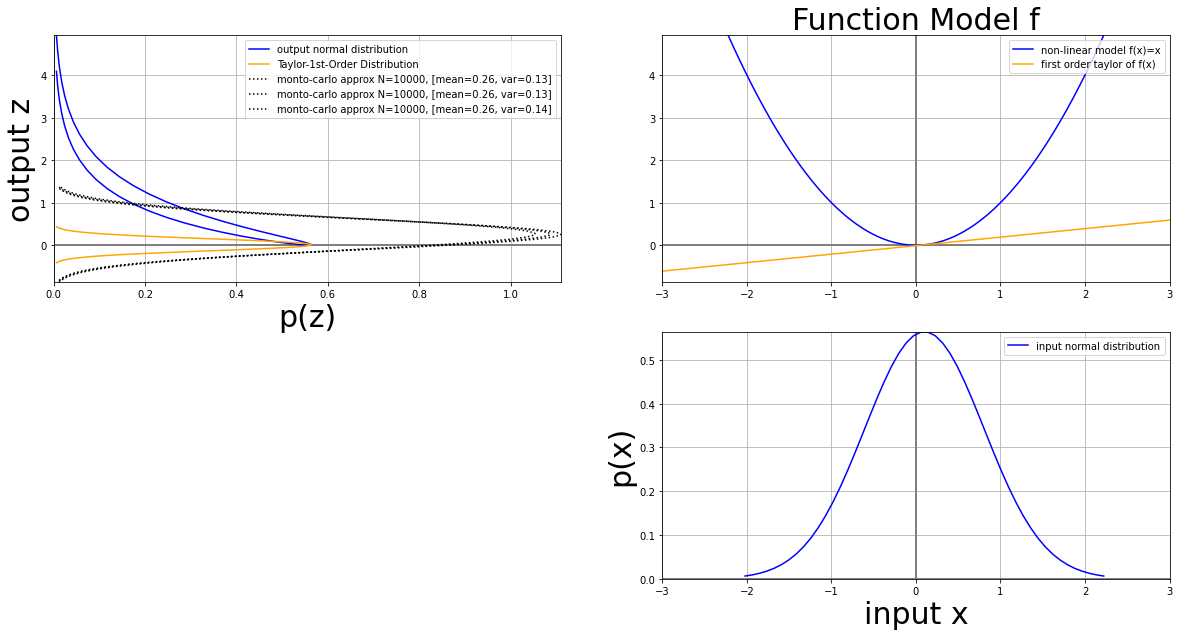

In [48]:
x_range, x_num = (-3., 3.), 100
x_mean, x_sigma = 0.1, 0.5

ekf_visu = EKF_Visualization(
    model=f,
    model_taylor=f_taylor_order_1,
    x_mean=x_mean,
    x_sigma=x_sigma,
    x_model_range=x_range,
    samples_num=100,
    monto_carlo_sizes=[10000, 10000, 10000])

ekf_visu.update_plot()

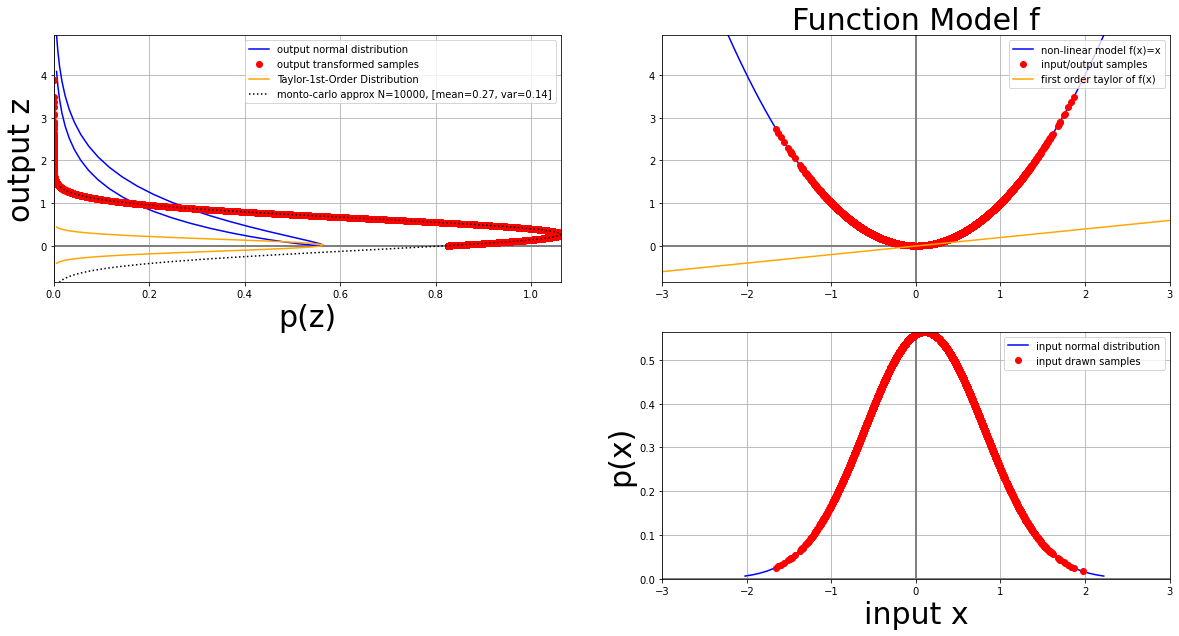

In [49]:
x_range, x_num = (-3., 3.), 100
x_mean, x_sigma = 0.1, 0.5

ekf_visu = EKF_Visualization(
    model=f,
    model_taylor=f_taylor_order_1,
    x_mean=x_mean,
    x_sigma=x_sigma,
    x_model_range=x_range,
    samples_num=100,
    monto_carlo_sizes=[10000]
)

ekf_visu.update_plot()

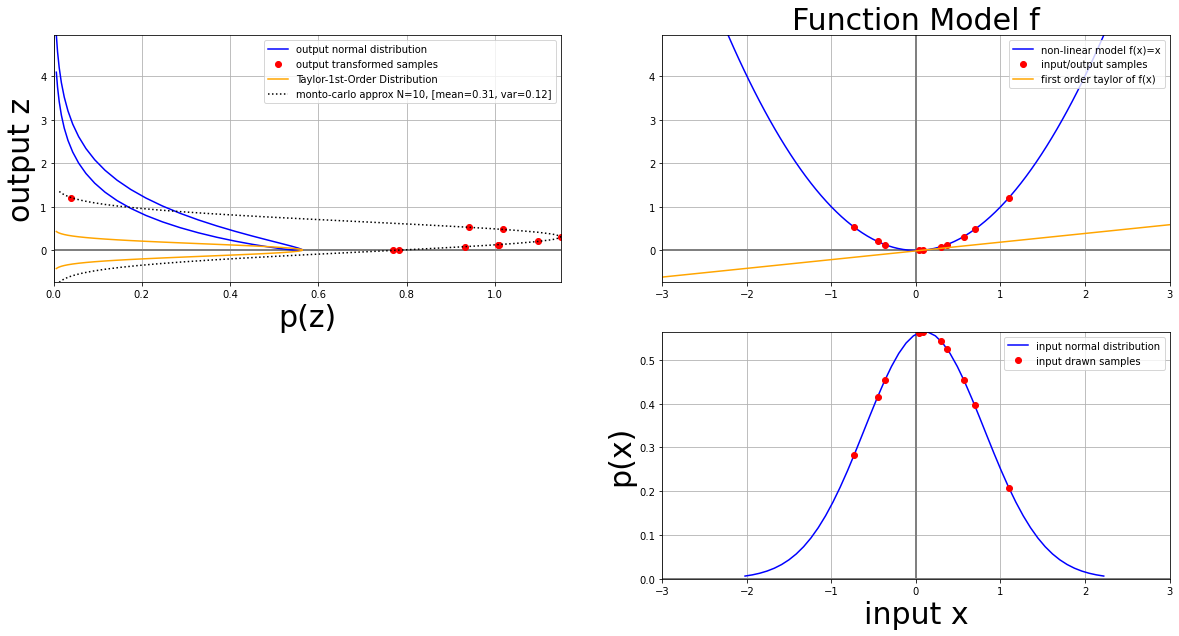

In [50]:
x_range, x_num = (-3., 3.), 100
x_mean, x_sigma = 0.1, 0.5

ekf_visu = EKF_Visualization(
    model=f,
    model_taylor=f_taylor_order_1,
    x_mean=x_mean,
    x_sigma=x_sigma,
    x_model_range=x_range,
    samples_num=100,
    monto_carlo_sizes=[10]
)

ekf_visu.update_plot()

# Unscented Transformation

The n-dimensional random variable $x$ with mean $\bar x$ and covariance $P_{xx}$ is approximated by $2n+1$ weighted points given by:

$$
\begin{align}
\chi_0 &= \bar{x} \\
\chi_i &= \bar{x} + \left( \sqrt{(n + \kappa) P_{xx}} \right)_i \\
\chi_{i+n} &= \bar{x} - \left( \sqrt{(n + \kappa) P_{xx}} \right)_i
\end{align}
$$

where subscription $i$ indicates the coloumn of the square root of covariance $P_{xx}$ [eg. $P_{xx}(:, i)$]

and its associated weights with $i$th point:

$$
\begin{align}
W_0 &= \frac{\kappa}{n+\kappa} \\
W_i &= \frac{1}{2(n+\kappa)} \\
W_{i+n} &= \frac{1}{2(n+\kappa)}
\end{align}
$$


## Propagate through Non-linear Model

$$
Z_i = \sum_{i=0}^{N} f(X_i)
$$

## Weighted Mean and Covariance

The mean is given by the weighted average of the transformed points:

$$
\bar{z} = \sum_{i=0}^{2n} W_i Z_i
$$

The covariance is given by the weighted outer producted of the transformed points.

$$
P_{zz} = \sum_{i=0}^{2n} W_i \left(Z_{i} - \bar{z}\right) \left(Z_{i} - \bar{z}\right)^T
$$

In [51]:
from scipy.stats import multivariate_normal

class UnscentedTranform(object):
    def __init__(self, f, x, P, kappa):
        # dimension of state vector
        if hasattr(x, "__len__"):
            self.n = len(x)
        else:
            self.n = 1
        
        self.f = f
        
        self.m = (2 * self.n) + 1 # number of sigma points
        
        self.x = np.asarray(x)
        self.P = np.asarray(P).reshape([self.n, self.n])
        self.kappa = kappa
        
        self.X = self.calculate_sigma_points()
        self.W = self.calculate_weights()
        
        if (np.isscalar(x) == 1):
            #self.p = multivariate_normal.pdf(self.X, mean=self.x, cov=self.P)
            self.p = gaussian_pdf(self.X, self.x, self.P)
        
        self.Y = f(self.X)
        
        self.y, self.Pyy = self.calculate_mean_and_covariance()
        
    def calculate_sigma_points(self):
        X = np.zeros((self.n, self.m))
        x = np.reshape(self.x, [self.n,])       
        X[:, 0] = x
        
        for i in range(self.n):
            P_sqrt = np.linalg.cholesky(self.P)
                
            scaler = np.sqrt(self.n + self.kappa)
            
            X[:, i+1]        = x + (scaler * P_sqrt[:, i])
            X[:, i+self.n+1] = x - (scaler * P_sqrt[:, i])
            
        return X
    
    def calculate_weights(self):
        W = np.ones((1, self.m)) * (0.5 / (self.n + self.kappa))
        W[0, 0] *= 2.0 * self.kappa
        return W
    
    def calculate_mean_and_covariance(self):
        y = np.zeros((self.n, ))
        
        for i in range(self.m):
            y += self.W[0, i] * self.Y[:, i]
        
        Pyy = np.zeros((self.n, self.n))
        for i in range(self.m):
            devYi = (self.Y[:, i] - y).reshape([self.n, 1])
            P_i = self.W[0, i] * devYi @ np.transpose(devYi)
            Pyy += P_i
    
        return y, Pyy
    
    def show_summary(self):
        print(f'self.x = \n{self.x} \n\n')
        print(f'self.P = \n{self.P} \n\n')
        print(f'self.kappa = \n{self.kappa} \n\n')
        print(f'self.n = \n{self.n} \n\n')
        print(f'self.m = \n{self.m} \n\n')
        print(f'self.X = \n{self.X} \n\n')
        print(f'self.W = \n{self.W} \n\n')
        #print(f'self.p= \n{self.p}\n\n')
        print(f'np.sqrt(self.P) = \n{np.sqrt(self.P)} \n\n')
        print(f'self.Y = \n{self.Y} \n\n')
        print(f'self.y = \n{self.y} \n\n')
        print(f'self.Pyy = \n{self.Pyy} \n\n')

In [52]:
x = np.array([[0.0]])
P = np.array([[0.5]])
kappa = 0.0

unscented_transform = UnscentedTranform(f, x, P, kappa)

unscented_transform.show_summary()

self.x = 
[[0.]] 


self.P = 
[[0.5]] 


self.kappa = 
0.0 


self.n = 
1 


self.m = 
3 


self.X = 
[[ 0.          0.70710678 -0.70710678]] 


self.W = 
[[0.  0.5 0.5]] 


np.sqrt(self.P) = 
[[0.70710678]] 


self.Y = 
[[0.  0.5 0.5]] 


self.y = 
[0.5] 


self.Pyy = 
[[0.]] 




In [53]:
x = np.array([[2.0],[1.0]])
P = np.array([[0.1, 0.0],[0.0, 0.1]])
kappa = 0.0

unscented_transform = UnscentedTranform(f, x, P, kappa)

unscented_transform.show_summary()

self.x = 
[[2.]
 [1.]] 


self.P = 
[[0.1 0. ]
 [0.  0.1]] 


self.kappa = 
0.0 


self.n = 
2 


self.m = 
5 


self.X = 
[[2.        2.4472136 2.        1.5527864 2.       ]
 [1.        1.        1.4472136 1.        0.5527864]] 


self.W = 
[[0.   0.25 0.25 0.25 0.25]] 


np.sqrt(self.P) = 
[[0.31622777 0.        ]
 [0.         0.31622777]] 


self.Y = 
[[4.         5.98885438 4.         2.41114562 4.        ]
 [1.         1.         2.09442719 1.         0.30557281]] 


self.y = 
[4.1 1.1] 


self.Pyy = 
[[ 1.61 -0.01]
 [-0.01  0.41]] 




In [54]:
def make_figure(xlims=None):
    figure, ax = plt.subplots(figsize=(30, 10))

    ax.axvline(c='grey', lw=2)
    ax.axhline(c='grey', lw=2)

    ax.grid(visible=True)

    ax.set_xlabel('x', fontsize=30)
    ax.set_ylabel('p(x)', fontsize=30)

    if (xlims != None):
        ax.set_xlim(xlims[0], xlims[1])

    return figure, ax


def add_absolute_position(ax, x, p, color, set_label=True):
    label = ''
    if (set_label == True):
        label=f'x={x}'
        
    ax.vlines(x, 0, p, color=color, label=label, linewidths=5)

       
def add_gaussian_bel(ax, x, var, color, visualize_details=False):
    p = gaussian_pdf(x, x, var)
    #p = norm(x, var).pdf(x)
    #add_absolute_position(ax, x, p, color, False)
    
    x_bel, p_bel = generate_normal_samples(x, var)
    ax.plot(x_bel, p_bel, color=color, label=f'x={round(x, 2)}, var={round(var, 2)}')
    
    if visualize_details == True:
        sigma = np.sqrt(var)
        sigma1_range = (x - sigma, x + sigma)      # sigma 1 x-range
        sigma2_range = (x - sigma*2, x + sigma*2)  # sigma 2 x-range
        sigma3_range = (x - sigma*3, x + sigma*3)  # sigma 3 x-range
        
        # fill sigma 1 area
        ax.fill_between(x_bel, p_bel, where=((x_bel >= sigma1_range[0]) & (x_bel <= sigma1_range[1])), color='C0', alpha=0.3)
        
        # fill sigma 2 areas
        ax.fill_between(x_bel, p_bel, where=((x_bel >= sigma2_range[0]) & (x_bel <= sigma1_range[0])), color='C1', alpha=0.3)
        ax.fill_between(x_bel, p_bel, where=((x_bel <= sigma2_range[1]) & (x_bel >= sigma1_range[1])), color='C1', alpha=0.3)
        
        # fill sigma 3 areas
        ax.fill_between(x_bel, p_bel, where=((x_bel >= sigma3_range[0]) & (x_bel <= sigma2_range[0])), color='C2', alpha=0.3)
        ax.fill_between(x_bel, p_bel, where=((x_bel <= sigma3_range[1]) & (x_bel >= sigma2_range[1])), color='C2', alpha=0.3)
        
        # arrow marking sigma 1 area
        ax.arrow(x, -0.25, sigma1_range[0], 0, head_length=0.01, head_width = 0.05, width = 0.01, length_includes_head = True)
        ax.arrow(x, -0.25, sigma1_range[1], 0, head_length=0.01, head_width = 0.05, width = 0.01, length_includes_head = True)
        
        # arrow marking sigma 2 area
        ax.arrow(x, -0.5, sigma2_range[0], 0, head_length=0.01, head_width = 0.05, width = 0.01, length_includes_head = True)
        ax.arrow(x, -0.5, sigma2_range[1], 0, head_length=0.01, head_width = 0.05, width = 0.01, length_includes_head = True)
        
        # arrow marking sigma 3 area
        ax.arrow(x, -0.75, sigma3_range[0], 0, head_length=0.01, head_width = 0.05, width = 0.01, length_includes_head = True)
        ax.arrow(x, -0.75, sigma3_range[1], 0, head_length=0.01, head_width = 0.05, width = 0.01, length_includes_head = True)
        
        # area covered by sigma 1
        ax.text(x, -(0.25-0.05), "68.27%", fontsize=20)
        
        # area covered by sigma 2
        ax.text(x, -(0.5-0.05), "95.45%", fontsize=20)
        
        # area covered by sigma 3
        ax.text(x, -(0.75-0.05), "99.73%", fontsize=20)
        

def darw_sigma_points(ax, sigmas, x, P, color, marker):
    p = gaussian_pdf(sigmas, x, P)
    ax.plot(sigmas, p, color=color, marker=marker, markersize=20, linestyle='', label='')

        
def update_plot():
    plt.legend(prop={'size': 30})
    plt.show()
    
    

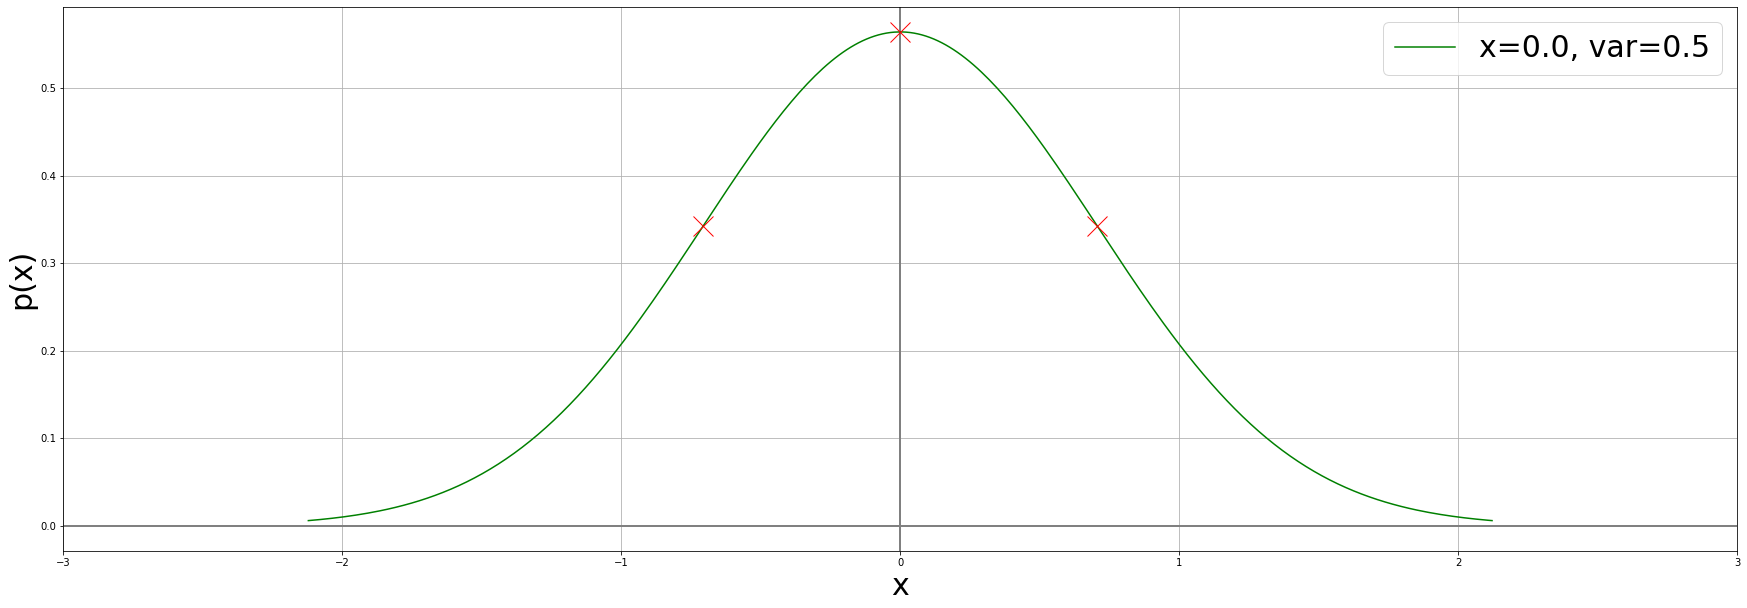

In [55]:
x = 0.0
P = 0.5
kappa = 0.0

unscented_transform = UnscentedTranform(f, x, P, kappa)

fig, ax = make_figure(xlims=(-3, 3))

add_gaussian_bel(ax, x, P, 'green')
darw_sigma_points(ax, unscented_transform.X, x, P, color='red', marker='x')

update_plot()

In [56]:
def calculate_weighted_mean_and_covariance(X, W):
    
    n, m = np.shape(X)
    
    x = np.zeros((n, 1))
    P = np.zeros((n, n))
    
    for i in range(m):
        x += X[:, i] * W[0, i]
    
    for i in range(m):
        v = X[:, i] - x
        P += W[:, i] * (v @ v.transpose())
        
    return x, P

In [57]:
class UKF_Visualization(object):
    def __init__(self, model=None, x_mean=0.0, x_sigma=0.0, samples_num=100, x_model_range=[-1., 1.]):        
        '''
        initialize the class object
        
        model : model to be used for projection
        model_taylor : first order Taylor expansions of model f(x)
        
        x_mean : input mean
        x_sigma : input standard deviation
        
        x_model_range : range of values for plotting inputs of model and model_taylor
        z_model_range : range of values for plotting outputs of model and model_taylor
        
        '''       
        self.xlim_min, self.xlim_max = x_model_range
               
        self.x_mean = x_mean
        self.x_sigma = x_sigma
        
        self.z_mean = model(self.x_mean)
               
        self.model = model
        
        self.fig, self.axes = create_plot()
        
        kappa = 0.0
        unscented_transform = UnscentedTranform(model, x_mean, x_sigma, kappa)
        
        self.sigma_X = unscented_transform.X
        self.sigma_W = unscented_transform.W
        self.sigma_p = unscented_transform.p
        
    def update_plot(self):
        '''
        main function to execute the class plotting
        '''
        
        # ==============================================================================================
        # 1. generate 'x' samples to feed to the model 'f(x)'
        #
        x_norm_bel, p_norm_bel = generate_normal_samples(self.x_mean, self.x_sigma, num=50)
        x_sigma_pts, p_sigma_pts = self.sigma_X, self.sigma_p
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 2. propagate the 'x' samples through model 'f(x)' to obtain 'z' samples
        #
        x_model_curve = np.linspace(self.xlim_min, self.xlim_max, num=100)
        z_model_curve = self.model(x_model_curve)
        
        z_norm_bel = self.model(x_norm_bel)
        
        # ==============================================================================================
        
        # ==============================================================================================
        # 3. propagate sigma points through non-linear model
        # the calculate weighted mean and covariance
        #
        z_sigma_pts = self.model(x_sigma_pts)
        
        z_sigma_mean, z_sigma_cov = calculate_weighted_mean_and_covariance(z_sigma_pts, self.sigma_W)
        z_sigma_mean, z_sigma_cov = np.reshape(z_sigma_mean, [-1]), np.reshape(z_sigma_cov, [-1])
        
        z_sigma_bel, p_sigma_bel = generate_normal_samples(z_sigma_mean[0], z_sigma_cov[0], num=50) # for bell curve dist plotting
        z_sigma_bel, p_sigma_bel = np.reshape(z_sigma_bel, [-1]), np.reshape(p_sigma_bel, [-1])
        # ==============================================================================================
        
        # ==============================================================================================
        # 4. calculate mean and variance of the propagated samples 'z' from the non-linear function f(x)
        #
        
        monto_carlo_n10000 = MontoCarloSampler(nl_model=self.model, mean=self.x_mean, var=self.x_sigma, num=10000)
        z_monto_approx_10000, p_monto_approx_10000 = generate_normal_samples(monto_carlo_n10000.mean, monto_carlo_n10000.var, num=50)       
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 5. calculate the min and max samples to set plots limits
        #
        z_list = [z_norm_bel, z_monto_approx_10000, z_sigma_bel]
        z_lim_min, z_lim_max = np.min(z_list), np.max(z_list)
        p_input_max = np.max(p_norm_bel)
        p_output_max = np.max([p_norm_bel, p_monto_approx_10000, p_sigma_bel])
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 6. set plots limits
        #
        self.axes[0, 0].set_xlim(0., p_output_max)
        self.axes[0, 0].set_ylim(z_lim_min, z_lim_max)
        
        self.axes[1, 1].set_xlim(self.xlim_min, self.xlim_max)
        self.axes[1, 1].set_ylim(0., p_input_max)
        
        self.axes[0, 1].set_xlim(self.xlim_min, self.xlim_max)
        self.axes[0, 1].set_ylim(z_lim_min, z_lim_max)
        # ==============================================================================================
        
        
        # ==============================================================================================
        # 7. plot input normal distribution
        #
        self.axes[1, 1].plot(x_norm_bel, p_norm_bel, color='blue', label='input normal distribution')
        self.axes[1, 1].plot(x_sigma_pts, p_sigma_pts, color='red', marker='o', linestyle='', label='inputs drawn sigma points') # draw point
        # ==============================================================================================
    
    
        # ==============================================================================================
        # 8. plot output normal distributions
        # 
        self.axes[0, 0].plot(p_norm_bel, z_norm_bel, color='blue', label='output normal distribution')
        self.axes[0, 0].plot(p_sigma_pts, z_sigma_pts, color='red', marker='o', linestyle='', label='output propagated sigma points') # draw point
        
        #self.axes[0, 0].plot(p_monto_approx_10, z_monto_approx_10, color='black', linestyle=':', label=f'approx normal dist N={monto_carlo_n10.num}, [mean={round(monto_carlo_n10.mean,2)}, var={round(monto_carlo_n10.var,2)}]')       
        self.axes[0, 0].plot(p_monto_approx_10000, z_monto_approx_10000, color='blue', linestyle=':', label=f'approx normal dist N={monto_carlo_n10000.num}, [mean={round(monto_carlo_n10000.mean,2)}, var={round(monto_carlo_n10000.var,2)}]')
        self.axes[0, 0].plot(p_sigma_bel, z_sigma_bel, color='red', linestyle=':', label=f'approx normal dist from sigma points, [mean={round(z_sigma_mean[0],2)}, var={round(z_sigma_cov[0],2)}]')
        # ==============================================================================================
    
    
        # ==============================================================================================
        # 9. plot model curve
        #        
        self.axes[0, 1].plot(x_model_curve, z_model_curve, color='blue', label='non-linear model f(x)=x')
        self.axes[0, 1].plot(x_sigma_pts, z_sigma_pts, color='red', marker='o', linestyle='', label='first order taylor of f(x)') # draw point
        # ==============================================================================================
        

        self.axes[0, 0].legend(loc='upper right')
        self.axes[0, 1].legend(loc='upper right')
        self.axes[1, 1].legend(loc='upper right')
        

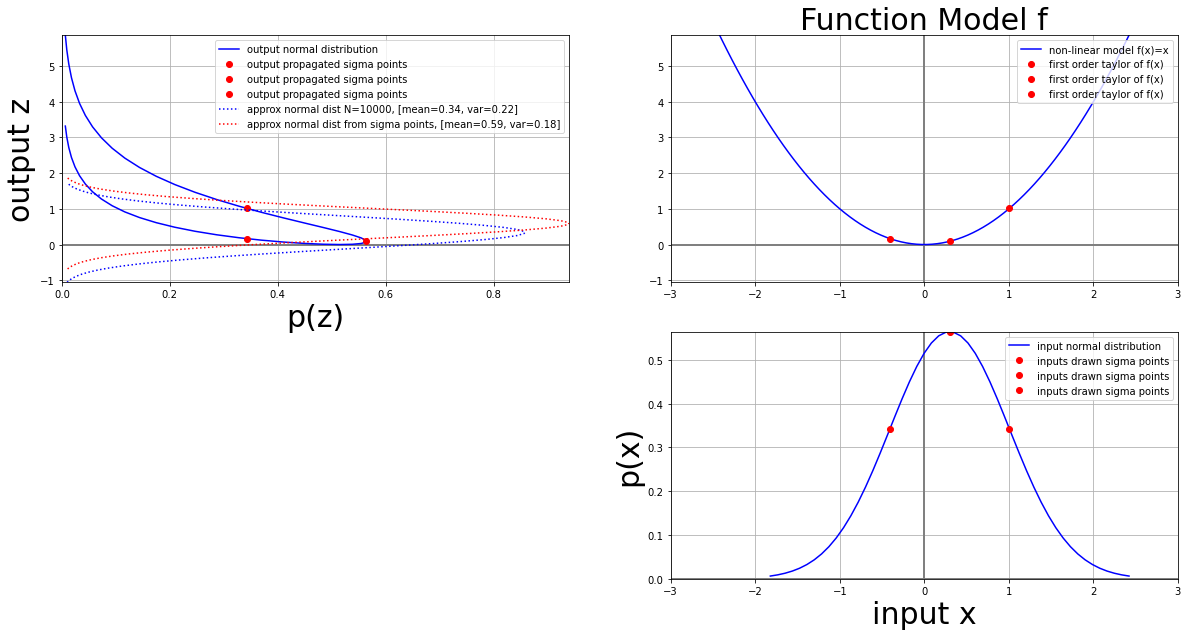

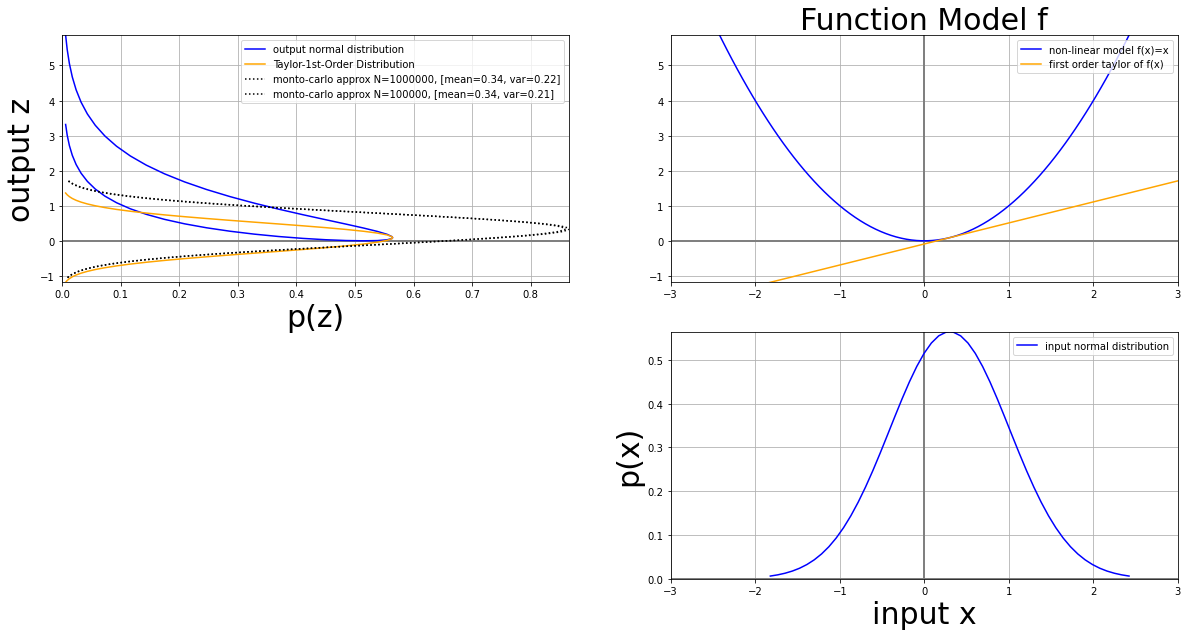

In [58]:
x_range, x_num = (-3., 3.), 100
x_mean, x_sigma = 0.3, 0.5

ukf_visu = UKF_Visualization(
    model=f, 
    x_mean=x_mean, 
    x_sigma=x_sigma, 
    x_model_range=x_range, 
    samples_num=100
)
ukf_visu.update_plot()

ekf_visu = EKF_Visualization(
    model=f, 
    model_taylor=f_taylor_order_1, 
    x_mean=x_mean, 
    x_sigma=x_sigma, 
    x_model_range=x_range, 
    samples_num=100,
    monto_carlo_sizes=[1000000, 100000]
)
ekf_visu.update_plot()